# AI vision via Raku

Anton Antonov   
[RakuForPrediction-book at GitHub](https://github.com/antononcube/RakuForPrediction-book)   
November 2023

## Introduction

In the fall of 2023 OpenAI introduced image vision model "gpt-4-vision-preview", [OAIb1].

The model "gpt-4-vision-preview" represents a significant enhancement to the GPT-4 model, providing developers and AI enthusiasts with a more versatile tool capable of interpreting and narrating images alongside text. This development opens up new possibilities for creative and practical applications of AI in various fields.

For example, consider the following Raku-developer-centric applications:

- Narration of UML diagrams
- Code generation from narrated (and suitably tweaked) narrations of architecture diagrams and charts
- Generating presentation content draft from slide images
- Extracting information from technical plots
- etc.

**Remark:** The model "gpt-4-vision-preview" is given as a ["chat completion model"](https://platform.openai.com/docs/api-reference/chat/create),
therefore, in this document we consider it to be a Large Language Model (LLM).

There are four ways to utilize image interpretation (or vision) services in Raku:

- Command Line Interface (CLI) script, [AAp1]
- Dedicated (chat completion) function, [AAp1]
- LLM functions, [AAp2]
- Dedicated notebook cell type, [AAp3, AAv1]

In this document only the first three are demonstrated. The fourth one is still "under design and consideration."

### Packages

Here are the Raku packages (namespaces) used below, [AAp1, AAp2, AAp3]:

In [23]:
use WWW::OpenAI;
use WWW::OpenAI::ChatCompletions;
use LLM::Functions;

-----

## CLI

The simplest way to use the OpenAI's vision service is through the CLI script of "WWW::OpenAI", [AAp1].

Here is an image (a resource file of [AAp1]):

![](https://raw.githubusercontent.com/antononcube/Raku-WWW-OpenAI/main/resources/ThreeHunters.jpg)

In [25]:
#% bash
openai-playground --images=https://raw.githubusercontent.com/antononcube/Raku-WWW-OpenAI/main/resources/ThreeHunters.jpg Describe the image

The image is an illustration featuring three raccoons in a vibrant, colorful woodland setting. The raccoons are positioned on the ground among the roots of a large tree that frames the scene. The tree's leaves exhibit a range of warm colors, predominantly in shades of orange, yellow, and green, suggesting a scene set in autumn.

The raccoons are depicted with their characteristic black facial markings and ringed tails. They appear curious and alert, with two of them facing forward and the third


-----

## Dedicated access function

Within a Raku script or REPL session OpenAI's vision service can be accessed with the function `openai-completion`.

If the function `openai-completion` is given a list of images, textual results corresponding to those images is returned.
The argument "images" is a list of image URLs, image file names, or image Base64 representations. (Any combination of those element types.)

Before demonstrating the vision functionality we get and show a couple images.

### Images

Here is URL of an image (https://i.imgur.com/LEGfCeql.jpg):

![](https://i.imgur.com/LEGfCeql.jpg)

We'll demonstrate how to display the second image by using the file path and the `encode-image` function from the `WWW::OpenAI::ChatCompletions` namespace. The `encode-image` function converts image files into Base64 image strings, which are a type of text representation of the image.

When we use the `openai-completion` function and provide a file name under the "images" argument, the `encode-image` function is automatically applied to that file.

Here's an example of how we apply `encode-image` to the image from a given file path (`$*HOME ~ '/Downloads/ThreeHunters.jpg'`):

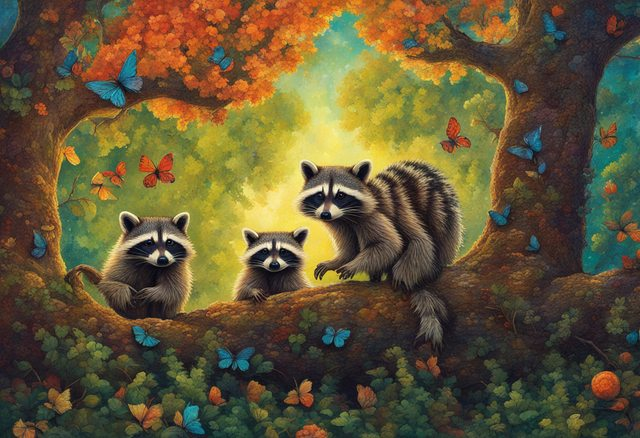

In [38]:
#% markdown
my $img3 = WWW::OpenAI::ChatCompletions::encode-image($*HOME ~ '/Downloads/ThreeHunters.jpg');
"![]($img3)"

### Image narration

Here is an image narration example with the two images above, again, one specified with a URL, the other with a file path:

In [27]:

my $url1 = 'https://i.imgur.com/LEGfCeql.jpg';
my $fname2 = $*HOME ~ '/Downloads/ThreeHunters.jpg';
my @images = [$url1, $fname2];

openai-completion("Give concise descriptions of the images.", :@images, max-tokens => 900, format => 'values');

1. The first image features a single raccoon perched on a tree branch surrounded by a multitude of colorful butterflies in an array of blues and oranges, set against a vibrant, nature-themed backdrop.

2. The second image depicts three raccoons on a tree branch in a forest setting, with two of them looking towards the viewer and one looking to the side. The background is filled with autumnal-colored leaves and numerous butterflies that match the whimsical atmosphere of the scene.

### Description of mind-map

Here is a more Raku-developer application -- getting a description of technical diagram or flowchart. 
Well, in this case a mind-map from [AA1]:

![](https://i.imgur.com/kcUcWnql.jpeg)

In [93]:
#% markdown

my $mm-descr = 
    openai-completion(
        "How many branches this mind-map has? Describe each branch separately. Use relevant emoji prefixes.", 
        images => 'https://imgur.com/kcUcWnq.jpeg', 
        max-tokens => 1024,
        format => 'values'
    );

$mm-descr

The mind-map has five branches, each representing a different aspect or functionality related to LLM (Large Language Models) services access. Here's the description of each branch with relevant emoji prefixes:

1. 🎨 **DALL-E**: This branch indicates that DALL-E, an AI system capable of creating images from textual descriptions, is related to or a part of LLM services.

2. 🤖 **ChatGPT**: This branch suggests that ChatGPT, which is likely a conversational AI based on GPT (Generative Pre-trained Transformer), is associated with LLM services.

3. 🧠 **PaLM**: This branch points to PaLM, suggesting that it is another model or technology related to LLM services. PaLM might stand for a specific model or framework in the context of language processing.

4. 💬 **LLM chat objects**: This branch leads to a node indicating chat-related objects or functionalities that are part of LLM services.

5. 📚 **Chatbooks**: This branch leads to a concept called "Chatbooks," which might imply a feature or application related to creating books from chat or conversational content using LLM services.

Each of these branches emanates from the central node labeled "LLM services access," indicating that they are all different access points or functionalities within the realm of large language model services.

------

## Programmatic

Let us show programmatic utilization of the vision capabilities.

Here is the workflow:

1. Ingest an image file and encode into a Base64 string
2. Make an LLM configuration with that image string (and corresponding model)
3. Synthesize a response to a basic request (like, image description)
   - Using `llm-synthesize`.
4. Make an LLM function for asking different questions over image
5. Ask questions and verify results
   - *Numerical questions are often wrong.*

### Image ingestion and encoding

Here we ingest the image and display it:

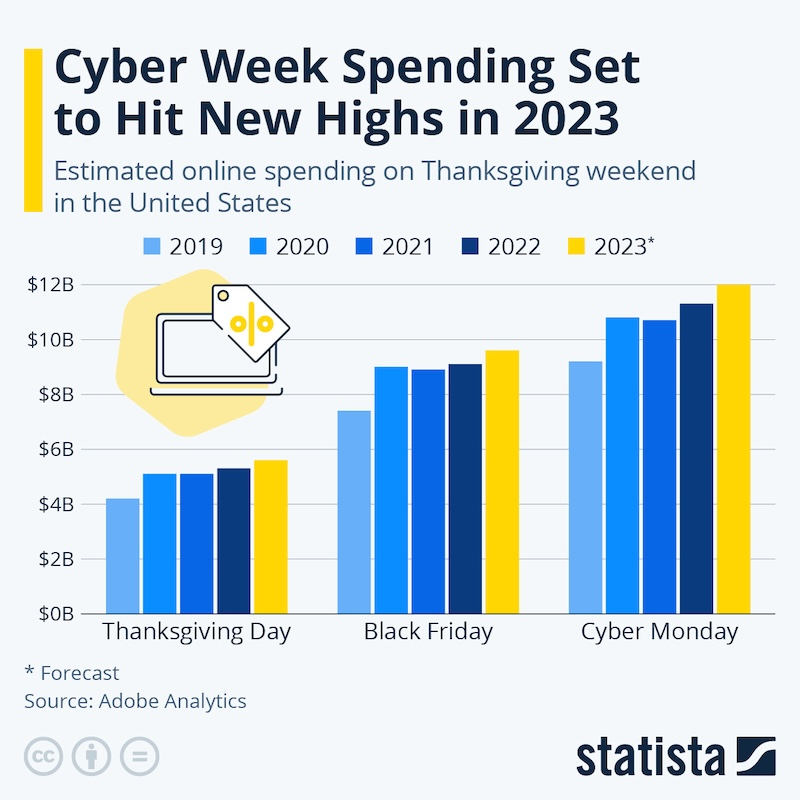

In [6]:
#%markdown
my $imgBarChart = WWW::OpenAI::ChatCompletions::encode-image($*HOME ~ '/Downloads/Cyber-Week-Spending-Set-to-Hit-New-Highs-in-2023-small.jpeg');
"![]($imgBarChart)"

**Remark:** The image was downloaded from the post ["Cyber Week Spending Set to Hit New Highs in 2023"](https://www.statista.com/chart/7045/thanksgiving-weekend-e-commerce-sales/).

### Configuration and synthesis

Here we make a suitable LLM configuration with the image:

In [15]:
my $confImg = llm-configuration("ChatGPT", model => 'gpt-4-vision-preview', images => $imgBarChart, temperature => 0.2);
$confImg.WHAT

(Configuration)

Here we synthesize a response of a image description request:

In [17]:
llm-synthesize("Describe the image.", e=> $confImg)

The image is an infographic titled "Cyber Week Spending Set to Hit New Highs in 2023." It presents a bar chart showing the estimated online spending on Thanksgiving weekend in the United States for the years 2019, 2020, 2021, 2022, and a forecast for 2023. The spending is broken down by three days: Thanksgiving Day, Black Friday, and Cyber Monday.

Each year is represented by a different color on the chart: 2019 is light blue, 2020 is dark blue, 2021 is even darker blue, 2022 is the darkest blue, and the forecast for 2023 is shown in yellow. The vertical axis of the chart measures spending in billions of dollars, ranging from $0B to $12B.

The chart indicates that spending has been increasing each year and is expected to reach new highs in 2023. For each of the three days, the bars rise in height from 2019 to the forecast for 2023, suggesting a steady growth in online spending during this period.

In the bottom left corner, there is a symbol indicating that the source of the data is Ad

### LLM function and repeated questioning

Here we define an LLM function that allows the multiple question request invocations over the image: 

In [20]:
my &fst = llm-function({"For the given image answer the question: $_ . Be as concise as possible in your answers."}, e => $confImg); 

-> **@args, *%args { #`(Block|3507283311664) ... }

In [21]:
&fst('How many years of presented in that image?')

Five years are presented in the image.

In [22]:
&fst('Which year has the highest value? What is that value?')

The year with the highest value is 2023, with a value of just over $11 billion.

**Remark:** Numerical value readings over technical plots or charts seem to be often wrong. OpenAI's vision model warns about this in the responses often enough.

______

## Dedicated notebook cells

In the context of the "recently-established" notebook solution "Jupyter::Chatbook", [AAp3], I am contemplating an extension to integrate OpenAI's vision service. 

The main challenges here include determining how users will specify images in the notebook, such as through URLs, file names, or Base64 strings, each with unique considerations. Additionally, I am exploring how best to enable users to input prompts or requests for image processing by the AI/LLM service. 

This integration, while valuable, it is not my immediate focus as there are programmatic ways to access OpenAI's vision service already. (See the previous section.)

-------

## Other workflows (story generation)

Instead of computational workflows consider the following "creative workflow":

1. Draw or LLM generate a few images that characterize parts of a story.
2. Narrate the images using the LLM "vision" functionality.
3. Use an LLM to generate a story over the narrations

**Remark:** Multi-modal LLM/AI systems already combine steps 2 and 3.

**Remark:** The workflow above (after it is programmed) can be executed multiple times until satisfactory results are obtained.

Image generation with DALL-E:

In [84]:
my @story-images = [
"a girl gets a basket with wine and food for her grandma.",
"a bear meets a girl carrying a basket in the forest.",
"a girl that gives food from a basket to a bear.",
"a bear builds a new house for girl's grandma."
].map({ openai-create-image( 'Painting in the style of John Bauer of ' ~ $_, response-format => 'b64_json', format => 'values') });

@story-images.elems

4

Here we display the images:

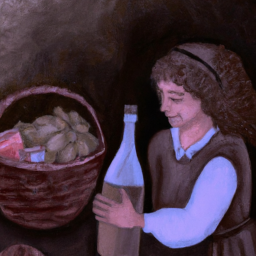

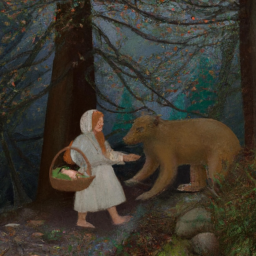

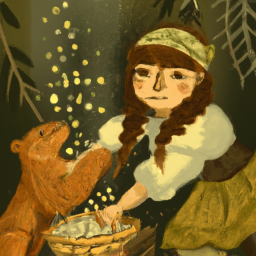

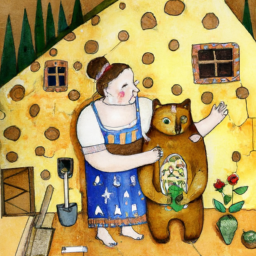

In [86]:
#% markdown
@story-images.map({ '![](data:image/jpeg;base64,' ~ $_ ~ ')' }).join("\n\n")

Here we get the image narrations (via the "AI vision service"):

In [87]:
my $story-images-descriptions = 
    openai-completion("Describe the images.",
        images => @story-images.map({ 'data:image/jpeg;base64,' ~ $_ ~ '' }).List,
        max-tokens => 900,
        format => 'values'
    );

$story-images-descriptions 

The images all depict illustrations involving human figures interacting with bears in various settings and styles:

1. The first image shows a character, likely a young girl, holding a large bottle. She is dressed in a traditional outfit with a headscarf, and there is a basket filled with what appears to be bread next to her. The setting is indoors with a dark background, and the lighting highlights the girl and the objects she is with.

2. In the second image, there is a scene set in a forest where a young girl, again in traditional dress with a headscarf, is facing a bear. She is carrying a basket and appears to be offering something to the bear or interacting with it in some way.

3. The third image depicts a girl with braids and a headband, wearing a traditional dress, sharing fish with a bear. The setting seems to be outdoors at night, and there are glowing lights around them, possibly fireflies.

4. The fourth image is a more whimsical and brightly colored illustration showing a 

Here we extract the descriptions only:

In [88]:
#% markdown
my @descr = $story-images-descriptions.split("\n", :skip-empty)[1..4];
@descr ==> to-html()

<ul><li>1. The first image shows a character, likely a young girl, holding a large bottle. She is dressed in a traditional outfit with a headscarf, and there is a basket filled with what appears to be bread next to her. The setting is indoors with a dark background, and the lighting highlights the girl and the objects she is with.</li><li>2. In the second image, there is a scene set in a forest where a young girl, again in traditional dress with a headscarf, is facing a bear. She is carrying a basket and appears to be offering something to the bear or interacting with it in some way.</li><li>3. The third image depicts a girl with braids and a headband, wearing a traditional dress, sharing fish with a bear. The setting seems to be outdoors at night, and there are glowing lights around them, possibly fireflies.</li><li>4. The fourth image is a more whimsical and brightly colored illustration showing a woman in a blue dress with an apron standing next to a bear outside a cottage. The bear is holding a basket of mushrooms, and the house appears to be covered in honeycomb patterns. There is also a shovel, some plants, and a window on the house, suggesting a domestic scene.</li></ul>

Here we generate the story from the descriptions above:

In [89]:
my $res = llm-synthesize(['Write a story that fits the following four descriptions:',|@descr], e=>llm-configuration('PaLM', max-tokens=>1200))

Once upon a time, there was a young girl named Anya who lived in a small village on the edge of a forest. Anya loved to go into the forest, and she would often spend her days exploring the trees and streams. One day, Anya was exploring the forest when she came across a bear. The bear was surprised to see Anya, but it didn't seem to be afraid of her. Anya cautiously approached the bear, and the two of them began to talk. Anya learned that the bear's name was Boris, and that he had been living in the forest for many years. Boris told Anya that he was lonely, and that he wished he had someone to talk to. Anya offered to be Boris's friend, and the two of them quickly became inseparable.

Anya and Boris would spend their days playing together in the forest. They would swim in the river, climb trees, and pick berries. Anya would tell Boris stories about her village, and Boris would tell Anya stories about the forest. One day, Anya's parents found out about her friendship with Boris. They wer

-----

## References

### Articles

[OAIb1] OpenAI team,
["New models and developer products announced at DevDay"](https://openai.com/blog/new-models-and-developer-products-announced-at-devday),
(2023),
[OpenAI/blog](https://openai.com/blog).

### Packages

[AAp1] Anton Antonov,
[WWW::OpenAI](https://github.com/antononcube/Raku-WWW-OpenAI) Raku package,
(2023),
[GitHub/antononcube](https://github.com/antononcube).


[AAp2] Anton Antonov,
[LLM::Functions](https://github.com/antononcube/Raku-LLM-Functions) Raku package,
(2023),
[GitHub/antononcube](https://github.com/antononcube).


[AAp3] Anton Antonov,
[Jupyter::Chatbook](https://github.com/antononcube/Raku-Jupyter-Chatbook) Raku package,
(2023),
[GitHub/antononcube](https://github.com/antononcube).


### Videos

[AAv1] Anton Antonov,
["Jupyter Chatbook LLM cells demo (Raku)"](https://www.youtube.com/watch?v=cICgnzYmQZg)
(2023),
[YouTube/@AAA4Prediction](https://www.youtube.com/@AAA4prediction).
